In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import xml.etree.ElementTree as ET  # For parsing the XML files
from xml.dom import minidom  # For prettifying the XML files
import os
import shutil  # For copying files from /kaggle/input to /kaggle/working

paths = []
for dirname, _, filenames in os.walk("/content/drive/MyDrive/Datasets/Project/Dataset1"):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))

# Split all paths by extension
xmls = []
jpgs = []
for path in paths:
    if path.split('.')[-1] == "xml":
        xmls.append(path)
    if path.split('.')[-1] == "jpg":
        jpgs.append(path)

print(f"{len(xmls)} XMLs + {len(jpgs)} JPGs = {len(paths)} paths")
#os.mkdir("/content/drive/MyDrive/Datasets/Project/images")  # Will contain only the images that were not excluded during preprocessing
#os.mkdir("/content/drive/MyDrive/Datasets/Project/masks")  # Will contain the masks for each image

390 XMLs + 480 JPGs = 870 paths


In [4]:
tree = ET.parse(xmls[4])
rough_string = ET.tostring(tree.getroot(), 'utf8')
reparsed = minidom.parseString(rough_string)
print(reparsed.toprettyxml(indent="  ").replace("&quot;", '"'))

<?xml version="1.0" ?>
<case>
  <number>15</number>
  <age>38</age>
  <sex>F</sex>
  <composition>predominantly solid</composition>
  <echogenicity>isoechogenicity</echogenicity>
  <margins>microlobulated</margins>
  <calcifications>microcalcifications</calcifications>
  <tirads>4c</tirads>
  <reportbacaf/>
  <reporteco/>
  <mark>
    <image>1</image>
    <svg>[{"points": [{"x": 315, "y": 99}, {"x": 304, "y": 98}, {"x": 298, "y": 96}, {"x": 266, "y": 101}, {"x": 258, "y": 105}, {"x": 249, "y": 108}, {"x": 241, "y": 113}, {"x": 230, "y": 120}, {"x": 222, "y": 130}, {"x": 222, "y": 130}, {"x": 213, "y": 141}, {"x": 212, "y": 150}, {"x": 212, "y": 157}, {"x": 213, "y": 165}, {"x": 214, "y": 183}, {"x": 220, "y": 193}, {"x": 225, "y": 197}, {"x": 229, "y": 202}, {"x": 234, "y": 206}, {"x": 241, "y": 208}, {"x": 242, "y": 208}, {"x": 246, "y": 208}, {"x": 260, "y": 210}, {"x": 267, "y": 216}, {"x": 269, "y": 218}, {"x": 282, "y": 225}, {"x": 289, "y": 229}, {"x": 298, "y": 236}, {"x": 319, 

In [5]:
# Create a dictionary for the data so that we can make it a pd.DataFrame
import pandas as pd
data = {
    "Number": [],
    "Age": [],
    "Sex": [],
    "Composition": [],
    "Echogenicity": [],
    "Margins": [],
    "Calcifications": [],
    "Tirads": [],
    "Reportbacaf": [],
    "Reporteco": [],
}
svg_strings = {}  # To hold the SVG of each image of every case
# Parse every xml file and add the data to the dictionary
for xml in xmls:
    tree = ET.parse(xml)
    root = tree.getroot()
    case_number = int(root.find("number").text)
    data["Number"].append(case_number)
    if root.find("age").text:
        data["Age"].append(int(root.find("age").text))
    else:
        data["Age"].append(root.find("age").text)
    data["Sex"].append(root.find("sex").text)
    data["Composition"].append(root.find("composition").text)
    data["Echogenicity"].append(root.find("echogenicity").text)
    data["Margins"].append(root.find("margins").text)
    data["Calcifications"].append(root.find("calcifications").text)
    data["Tirads"].append(root.find("tirads").text)
    data["Reportbacaf"].append(root.find("reportbacaf").text)
    data["Reporteco"].append(root.find("reporteco").text)
    # Get SVGs. Key: <{case number}_{image index}> which is the same as the respective image filename
    for mark in root.findall("mark"):
        image_idx = mark.find("image").text
        svg_strings[f"{case_number}_{image_idx}"] = mark.find("svg").text

df = pd.DataFrame(data)
df.sort_values(by="Number", inplace=True)
df.set_index("Number", inplace=True)
df.head(150)

,Age,Sex,Composition,Echogenicity,Margins,Calcifications,Tirads,Reportbacaf,Reporteco
Number,,,,,,,,,
1,NaN,None,None,None,None,None,None,None,None
2,49.0,F,solid,hyperechogenicity,well defined,non,2,None,None
3,31.0,F,spongiform,isoechogenicity,well defined,microcalcifications,4a,None,None
4,37.0,F,spongiform,isoechogenicity,well defined,microcalcifications,4a,None,None
5,47.0,F,solid,hypoechogenicity,ill defined,microcalcifications,5,None,None
...,...,...,...,...,...,...,...,...,...
147,NaN,None,None,None,None,None,None,None,None
148,37.0,F,solid,hypoechogenicity,well defined,non,4b,None,None
149,78.0,M,None,None,None,None,None,None,None


In [6]:
# See how many values are reported for each attribute
# We can see that "Reportbacaf" is empty, so we can safely remove it
df.count()

Age               304
Sex               305
Composition       200
Echogenicity      200
Margins           297
Calcifications    299
Tirads            298
Reportbacaf         0
Reporteco          21
dtype: int64

In [7]:
df.head(250)

,Age,Sex,Composition,Echogenicity,Margins,Calcifications,Tirads,Reportbacaf,Reporteco
Number,,,,,,,,,
1,NaN,None,None,None,None,None,None,None,None
2,49.0,F,solid,hyperechogenicity,well defined,non,2,None,None
3,31.0,F,spongiform,isoechogenicity,well defined,microcalcifications,4a,None,None
4,37.0,F,spongiform,isoechogenicity,well defined,microcalcifications,4a,None,None
5,47.0,F,solid,hypoechogenicity,ill defined,microcalcifications,5,None,None
...,...,...,...,...,...,...,...,...,...
249,NaN,None,None,None,None,None,None,None,None
250,NaN,F,None,None,None,None,None,None,None
251,73.0,F,solid,hyperechogenicity,well defined,microcalcifications,4b,None,None


In [8]:
#df.head(150)

In [9]:
from PIL import Image, ImageDraw

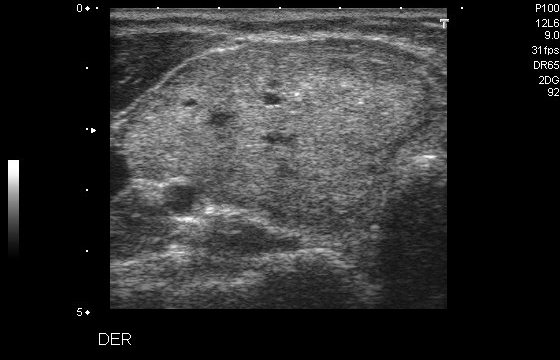

In [10]:
# Show the an image
Image.open(jpgs[0])

In [11]:
# Find all the different image dimensions; we can see that they all share the same
unique_dims = []
for jpg in jpgs:
    dims = Image.open(jpg).size
    if dims not in unique_dims:
        unique_dims.append(dims)

print(unique_dims)

[(560, 360)]


In [12]:
image_size = unique_dims[0]

# Show the first key and value of the svg dictionary we created
list(svg_strings.items())[0]

('135_1',
 '[{"points": [{"x": 394, "y": 126}, {"x": 386, "y": 133}, {"x": 377, "y": 136}, {"x": 358, "y": 146}, {"x": 352, "y": 155}, {"x": 350, "y": 159}, {"x": 348, "y": 164}, {"x": 347, "y": 170}, {"x": 343, "y": 177}, {"x": 337, "y": 184}, {"x": 343, "y": 206}, {"x": 344, "y": 217}, {"x": 344, "y": 224}, {"x": 355, "y": 234}, {"x": 362, "y": 237}, {"x": 370, "y": 242}, {"x": 375, "y": 243}, {"x": 380, "y": 244}, {"x": 389, "y": 245}, {"x": 398, "y": 245}, {"x": 414, "y": 245}, {"x": 420, "y": 242}, {"x": 430, "y": 215}, {"x": 434, "y": 207}, {"x": 438, "y": 197}, {"x": 440, "y": 191}, {"x": 438, "y": 179}, {"x": 432, "y": 172}, {"x": 432, "y": 170}, {"x": 432, "y": 160}, {"x": 430, "y": 149}, {"x": 428, "y": 146}, {"x": 425, "y": 134}, {"x": 421, "y": 132}, {"x": 416, "y": 132}, {"x": 406, "y": 128}, {"x": 404, "y": 127}, {"x": 395, "y": 125}, {"x": 395, "y": 125}, {"x": 391, "y": 125}], "annotation": {}, "regionType": "freehand"}, {"points": [{"x": 212, "y": 136}, {"x": 211, "y":

In [13]:
# create a mask for each image based on the svg provided
no_mask = 0  # to count how many SVGs are empty
with_syntax_error = 0  # to count how many XMLs are not complete
for svg_name, svg_str in svg_strings.items():
    img = Image.new("1", image_size)
    draw = ImageDraw.Draw(img)

    if svg_str is None:
        no_mask += 1
        continue
    try:
        svg_content = eval(svg_str)
    except SyntaxError:
        with_syntax_error += 1
        continue
    for area in svg_content:
        points = [(point["x"], point["y"]) for point in area["points"]]
        draw.polygon(points, fill='white')
    img.save(f"/content/drive/MyDrive/Datasets/Project/masks/{svg_name}.jpg")
    shutil.copyfile(
        f"/content/drive/MyDrive/Datasets/Project/Dataset1/{svg_name}.jpg",
        f"/content/drive/MyDrive/Datasets/Project/images/{svg_name}.jpg",
    )

In [14]:
# We do not store images of either of the categories below
print(f"{no_mask} SVGs were empty")
print(f"{with_syntax_error} XMLs were not complete")

6 SVGs were empty
8 XMLs were not complete


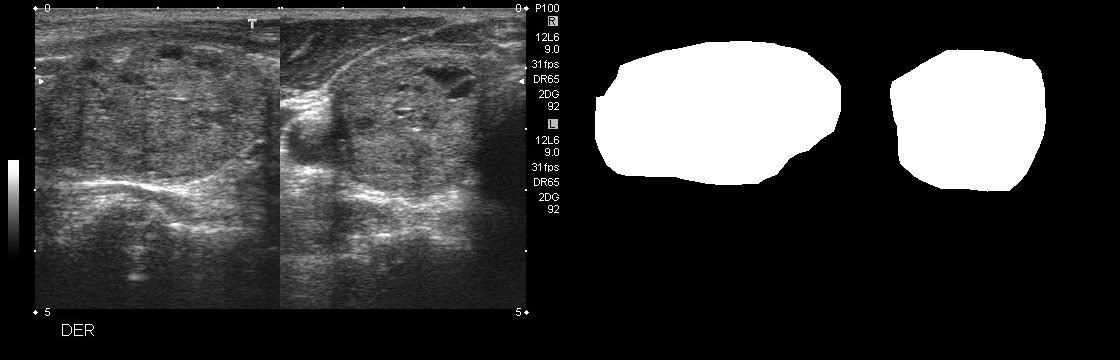

In [15]:
# Show an image and its mask
both = Image.new('RGB', (image_size[0] * 2, image_size[1]))
img = Image.open(f"/content/drive/MyDrive/Datasets/Project/images/{svg_name}.jpg")
mask = Image.open(f"/content/drive/MyDrive/Datasets/Project/masks/{svg_name}.jpg")
both.paste(img)
both.paste(mask, (image_size[0], 0))
both


In [16]:
Img=[]
mks=[]
for svg_name,svg_str in svg_strings.items():
    if svg_str is None:
        no_mask += 1
        continue
    Img.append(f"/content/drive/MyDrive/Datasets/Project/images/{svg_name}.jpg")
    mks.append(f"/content/drive/MyDrive/Datasets/Project/masks/{svg_name}.jpg")

In [17]:
len(Img)

474

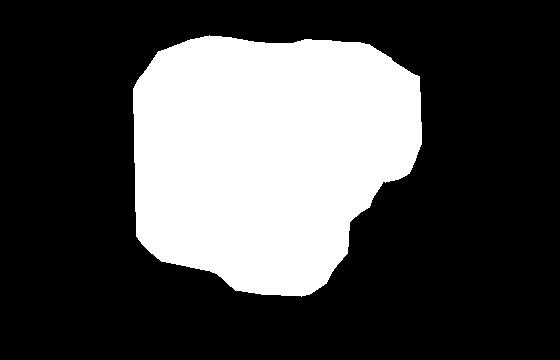

In [18]:
Image.open(mks[40])

In [19]:
from PIL import Image
import numpy as np
import math

# Open the mask image and convert to grayscale
mask_image = Image.open(mks[25]).convert('L')
mask_array = np.array(mask_image)

# Extract coordinates of white pixels
white_pixels = np.column_stack(np.where(mask_array == 255))

# Function to calculate the distance between two points
def calculate_distance(p1, p2):
    return math.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

# Calculate the maximum distance (diameter) between any two white pixels
max_distance = 0
for i in range(len(white_pixels)):
    for j in range(i + 1, len(white_pixels)):
        dist = calculate_distance(white_pixels[i], white_pixels[j])
        if dist > max_distance:
            max_distance = dist

print(f"The diameter of the masked area is {max_distance} pixels.")


The diameter of the masked area is 338.42724476613876 pixels.


In [20]:
from tensorflow.keras.utils import normalize
import os
import cv2
from PIL import Image
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.optimizers import Adam
import glob

In [21]:
import tensorflow as tf

In [22]:
paths = []
for dirname, _, filenames in os.walk("/content/drive/MyDrive/Datasets/Project/images/"):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))

In [23]:
paths2 = []
for dirname, _, filenames in os.walk("/content/drive/MyDrive/Datasets/Project/masks"):
    for filename in filenames:
        paths2.append(os.path.join(dirname, filename))

In [24]:
X=[]
for x in paths:
    X.append(Image.open(x))

In [25]:
print(paths[465])
print(paths2[465])

/content/drive/MyDrive/Datasets/Project/images/96_1.jpg
/content/drive/MyDrive/Datasets/Project/masks/96_2.jpg


In [26]:
Y=[]
for y in paths2:
    Y.append(Image.open(y))

In [27]:
input_images=[]
for i in X:
    input_images.append(tf.convert_to_tensor(i))

In [28]:
print(input_images[0])

tf.Tensor(
[[[ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]
  ...
  [ 5  5  5]
  [ 0  0  0]
  [ 2  2  2]]

 [[ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]
  ...
  [ 3  3  3]
  [16 16 16]
  [ 0  0  0]]

 [[ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]
  ...
  [ 0  0  0]
  [ 5  5  5]
  [ 0  0  0]]

 ...

 [[ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]
  ...
  [ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]]

 [[ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]
  ...
  [ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]]

 [[ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]
  ...
  [ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]]], shape=(360, 560, 3), dtype=uint8)


In [29]:
input_masks=[]
for y in Y:
    input_masks.append(tf.convert_to_tensor(y))

In [30]:
input_masks=tf.expand_dims(input_masks,axis=3)

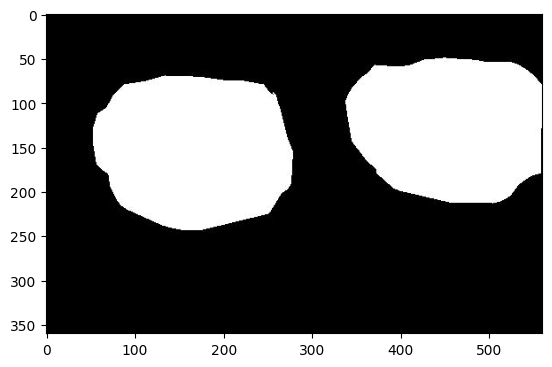

In [31]:
plt.imshow(input_masks[0],cmap='gray')

In [32]:
def resize(input_image):
   input_image = tf.image.resize(input_image, (256, 256), method="nearest")
   return input_image

In [33]:
def augment(input_image, input_mask):
   if tf.random.uniform(()) > 0.5:
       # Random flipping of the image and mask
       input_image = tf.image.flip_left_right(input_image)
       input_mask = tf.image.flip_left_right(input_mask)

   return input_image, input_mask

In [34]:
def normalize(input_image, input_mask):
   input_image = tf.cast(input_image, tf.float32) / 255.0
   #input_mask -= 1
   return input_image, input_mask

In [35]:
input_images=resize(input_images)
input_masks=resize(input_masks)

In [36]:
input_images[0].shape

TensorShape([256, 256, 3])

In [37]:
input_masks[0].shape

TensorShape([256, 256, 1])

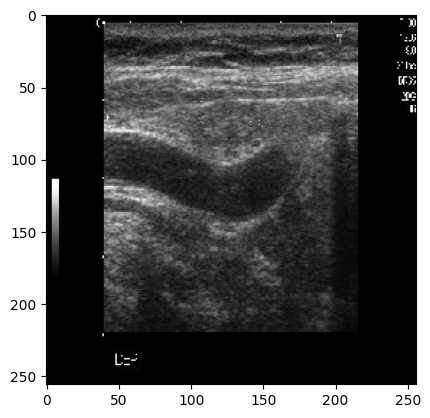

In [38]:
plt.imshow(input_images[42])

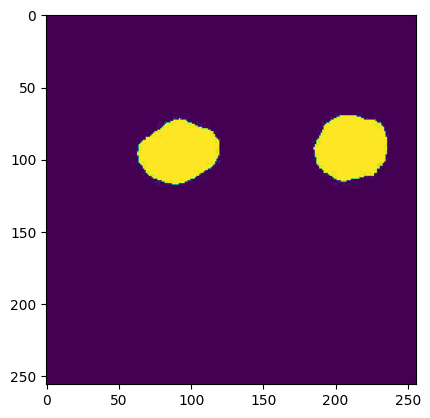

In [39]:
plt.imshow(input_masks[42])

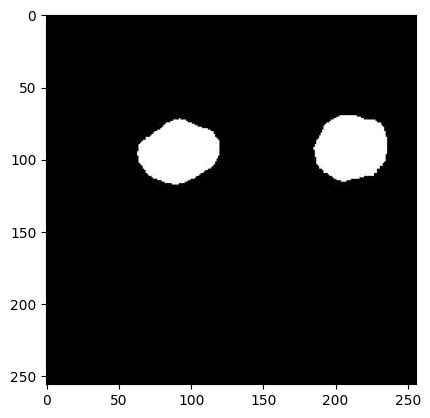

In [40]:
plt.imshow(input_masks[42],cmap='gray')

Segmentaion

In [41]:
                                   #segnentation

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate


def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network.
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x
    #Encoder block: Conv block followed by maxpooling


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

#Decoder block
#skip features gets input from encoder for concatenation

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x
#Build Unet using the blocks
def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    if n_classes == 1:  #Binary
      activation = 'sigmoid'
    else:
      activation = 'softmax'

    outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(d4)  #Change the activation based on n_classes
    print(activation)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [42]:
X_train=input_images[:300]
Y_train=input_masks[:300]
X_test=input_images[300:]
Y_test=input_masks[300:]

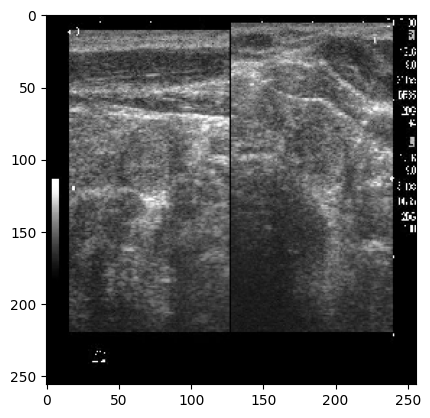

In [43]:
plt.imshow(X_train[23])

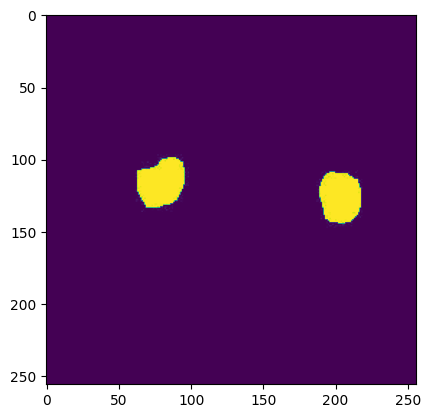

In [44]:
plt.imshow(Y_train[23])

In [45]:
X_train.shape
print(X_train.shape)
Y_train.shape

(300, 256, 256, 3)


TensorShape([300, 256, 256, 1])

In [46]:
IMG_HEIGHT=X_train.shape[1]
IMG_WIDTH=X_train.shape[2]
IMG_CHANNELS=X_train.shape[3]
input_shape=(IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS)

In [47]:
model = build_unet(input_shape, n_classes=1)
model.compile(optimizer=Adam(learning_rate = 1e-3), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

sigmoid
Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 256, 256, 64)         0         ['batch_normalizat

In [ ]:
history = model.fit(X_train, Y_train,
                    batch_size =20,
                    verbose=1,
                    epochs=3,
                    validation_data=(X_test, Y_test),
                    shuffle=False)

Epoch 1/3
15/15 [==============================] - 2292s 154s/step - loss: -81.8178 - accuracy: 0.5677 - val_loss: 21978220.0000 - val_accuracy: 0.9167
Epoch 2/3
15/15 [==============================] - 2287s 154s/step - loss: -143.5559 - accuracy: 0.4279 - val_loss: 13277497.0000 - val_accuracy: 0.9167
Epoch 3/3
15/15 [==============================] - 2282s 154s/step - loss: -174.1285 - accuracy: 0.3295 - val_loss: 3493855.5000 - val_accuracy: 0.9166


Feature extraction

In [48]:
import cv2
import numpy as np
from skimage.feature import graycomatrix, graycoprops
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
def extract_features(image, mask):
    def extract_margin_features(mask):
        sobelx = cv2.Sobel(np.array(mask), cv2.CV_64F, 1, 0, ksize=5)
        sobely = cv2.Sobel(np.array(mask), cv2.CV_64F, 0, 1, ksize=5)
        gradient_magnitude = np.sqrt(sobelx**2 + sobely**2)
        mean_gradient = np.mean(gradient_magnitude)

        margin_subfeature = "smooth"
        counter_margin = 0
        if mean_gradient > 50:
            margin_subfeature = "irregular"
            counter_margin = 2
        elif 20 < mean_gradient <= 50:
            margin_subfeature = "illdefined"
            counter_margin = 0
        elif mean_gradient > 100:
            margin_subfeature = "extra_thyroidal_extension"
            counter_margin = 3

        return {
            "mean_gradient": mean_gradient,
            "subfeature": margin_subfeature,
            "counter": counter_margin
        }

    def extract_calcification_features(mask):
        local_thresh = cv2.adaptiveThreshold(np.array(mask), 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                             cv2.THRESH_BINARY, 11, 2)
        num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(local_thresh, connectivity=8)
        num_calcifications = num_labels - 1  # subtracting 1 to ignore background

        calcification_subfeature = "macrocalcification"
        counter_calcification = 1
        if num_calcifications > 10:
            calcification_subfeature = "microcalcification"
            counter_calcification = 3
        elif num_calcifications < 10:
            composition_subfeature = "None"
            counter_composition = 0

        return {
            "num_calcifications": num_calcifications,
            "subfeature": calcification_subfeature,
            "counter": counter_calcification
        }

    def extract_composition_features(image):
        high_intensity = np.mean(np.array(image)) > 200
        mean_intensity = np.mean(np.array(image))
        std_intensity = np.std(np.array(image))

        composition_subfeature = "mixed solid"
        counter_composition = 1
        if high_intensity:
            composition_subfeature = "solid"
            counter_composition = 2
        elif mean_intensity > 100:
            composition_subfeature = "spongiform"
            counter_composition = 0
        elif mean_intensity < 50:
            composition_subfeature = "cystic"
            counter_composition = 0

        return {
            "mean_intensity": mean_intensity,
            "std_intensity": std_intensity,
            "subfeature": composition_subfeature,
            "counter": counter_composition
        }

    def extract_echogenicity_features(image):
        gray_image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2GRAY)
        laplacian_var = cv2.Laplacian(gray_image, cv2.CV_64F).var()
        mean_intensity = np.mean(np.array(image))
        std_intensity = np.std(np.array(image))

        echogenicity_subfeature = "hypoechoic"
        counter_echogenicity = 2
        if mean_intensity < 50:
            echogenicity_subfeature = "very hypoechoic"
            counter_echogenicity = 3

        return {
            "mean_intensity": mean_intensity,
            "std_intensity": std_intensity,
            "laplacian_var": laplacian_var,
            "subfeature": echogenicity_subfeature,
            "counter": counter_echogenicity
        }


    margin_features = extract_margin_features(mask)
    calcification_features = extract_calcification_features(mask)
    composition_features = extract_composition_features(image)
    echogenicity_features = extract_echogenicity_features(image)

    return {
        "margin_features": margin_features,
        "calcification_features": calcification_features,
        "composition_features": composition_features,
        "echogenicity_features": echogenicity_features,
    }


Classification

In [49]:
def assign_tier(features):
    num_features = sum([
        features["composition_features"]["counter"] if features["composition_features"] else 0,
        features["echogenicity_features"]["counter"] if features["echogenicity_features"] else 0,
        features["margin_features"]["counter"] if features["margin_features"] else 0,
        features["calcification_features"]["counter"] if features["calcification_features"] else 0
    ])

    if num_features >= 8:
        tier_level = "5"
    elif num_features == 7 :
        tier_level = "4a"
    elif num_features ==5  or num_features == 6:
        tier_level = "4b"
    elif num_features == 4:
        tier_level = "4c"
    elif num_features == 3:
        tier_level = "3"
    elif num_features == 2:
        tier_level = "2"
    else:
        tier_level = "l"

    return tier_level


In [50]:
features_list = []
tiers = []

for img, mask in zip(input_images, input_masks):
    features = extract_features(img, mask)
    tier_level = assign_tier(features)
    features_list.append(features)
    tiers.append(tier_level)

def features_to_dataframe(features_list, tiers):
    data = {
        "mean_gradient": [],
        "num_calcifications": [],
        "mean_intensity_composition": [],
        "std_intensity_composition": [],
        "mean_intensity_echogenicity": [],
        "std_intensity_echogenicity": [],
        "laplacian_var_echogenicity": [],
        "tier": []
    }

    for features, tier in zip(features_list, tiers):

        if features.get("margin_features"):
            data["mean_gradient"].append(features["margin_features"].get("mean_gradient", None))
        else:
            data["mean_gradient"].append(None)

        if features.get("calcification_features"):
            data["num_calcifications"].append(features["calcification_features"].get("num_calcifications", None))
        else:
            data["num_calcifications"].append(None)

        if features.get("composition_features"):
            data["mean_intensity_composition"].append(features["composition_features"].get("mean_intensity", None))
            data["std_intensity_composition"].append(features["composition_features"].get("std_intensity", None))
        else:
            data["mean_intensity_composition"].append(None)
            data["std_intensity_composition"].append(None)

        if features.get("echogenicity_features"):
            data["mean_intensity_echogenicity"].append(features["echogenicity_features"].get("mean_intensity", None))
            data["std_intensity_echogenicity"].append(features["echogenicity_features"].get("std_intensity", None))
            data["laplacian_var_echogenicity"].append(features["echogenicity_features"].get("laplacian_var", None))
        else:
            data["mean_intensity_echogenicity"].append(None)
            data["std_intensity_echogenicity"].append(None)
            data["laplacian_var_echogenicity"].append(None)

        data["tier"].append(tier)

    return pd.DataFrame(data)

df_features = features_to_dataframe(features_list, tiers)

# Preprocess the data for classification
df_features.dropna(inplace=True)
X1 = df_features.drop(columns=["tier"])
y1 = df_features["tier"]

# Encode the target variable
tier_mapping = {"l": 0, "2": 1, "3": 2, "4c": 3, "4b": 4, "4a": 5, "5": 6}
y1 = y1.map(tier_mapping)

# Split the data
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X1_train = scaler.fit_transform(X1_train)
X1_test = scaler.transform(X1_test)

# Build a simple classification model
classification_model = Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X1_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax')
])

classification_model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
classification_model.summary()

# Train the classification model
classification_model.fit(X1_train, y1_train, epochs=20, validation_data=(X1_test, y1_test))

# Evaluate the model
loss, accuracy = classification_model.evaluate(X1_test, y1_test)
print(f"Test Accuracy: {accuracy:.2f}")

# Displaying the features and sub-features names and values
sample_image = input_images[121]
sample_mask = input_masks[121]
sample_features = extract_features(sample_image, sample_mask)
sample_tier = assign_tier(sample_features)

print(f"Extracted Features: {sample_features}")
print(f"Tier Level: {sample_tier}")

for feature_type, feature_values in sample_features.items():
    if feature_values is not None:
        print(f"{feature_type}:")
        for key, value in feature_values.items():
            print(f"  {key}: {value}")
    else:
        print(f"{feature_type}: None")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1024      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 7)                 455       
                                                                 
Total params: 9735 (38.03 KB)
Trainable params: 9735 (38.03 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
12/12 [==============================] - 1s 24ms/step - loss: 1.6265 - accuracy: 0.6183 - val_loss: 1.2238 - val_accuracy: 0.8723
Epoch 2/20
12/12 [==============================] - 0s 6ms/step - loss: 1.0459 - accuracy: 0.8656 - val_loss: 0.7377 - val_accuracy: 0.8723
Epoch

3/3 [==============================] - 0s 5ms/step
Confusion Matrix:
[[ 0  1]
 [ 0 93]]
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.99      1.00      0.99        93

    accuracy                           0.99        94
   macro avg       0.49      0.50      0.50        94
weighted avg       0.98      0.99      0.98        94



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


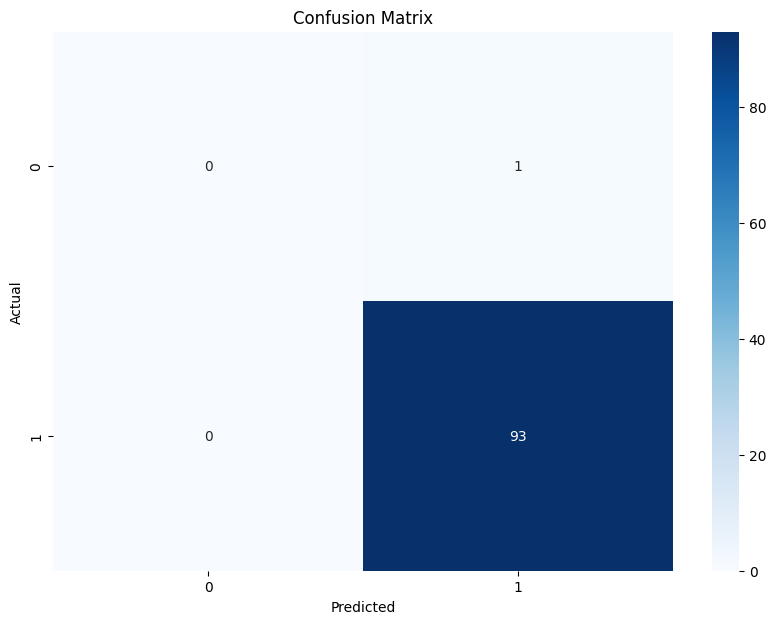

In [54]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report

# Generate predictions for the test set
y1_pred = classification_model.predict(X1_test)
y1_pred_classes = np.argmax(y1_pred, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y1_test, y1_pred_classes)

# Display the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Extract the number of unique classes from the test set
num_classes = len(np.unique(y1_test))

# Ensure the target names match the number of classes
target_names = [str(i) for i in range(num_classes)]

# Calculate classification report
class_report = classification_report(y1_test, y1_pred_classes, target_names=target_names)

# Display the classification report
print("Classification Report:")
print(class_report)

# Create a performance table
performance_table = pd.DataFrame(conf_matrix, index=target_names, columns=target_names)

# Add accuracy, precision, recall, and F1-score to the performance table
accuracy = np.diag(conf_matrix).sum() / conf_matrix.sum()
performance_table.loc['Total', :] = performance_table.sum(axis=0)
performance_table.loc[:, 'Total'] = performance_table.sum(axis=1)
performance_table.loc['Accuracy', 'Accuracy'] = accuracy


plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [55]:
print("Performance Table:")
print(performance_table)


Performance Table:
            0     1  Total  Accuracy
0         0.0   1.0    1.0       NaN
1         0.0  93.0   93.0       NaN
Total     0.0  94.0   94.0       NaN
Accuracy  NaN   NaN    NaN  0.989362


In [56]:
classification_model.save('py_thyroid_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [57]:
from sklearn.metrics import accuracy_score

loss, accuracy = model.evaluate(X_test, Y_test)
print(accuracy)

6/6 [==============================] - 328s 52s/step - loss: -29.7404 - accuracy: 0.1019
0.10189635306596756


In [ ]:
model.save('py_model.h5')